<p style="font-size:300%; text-align:center"> king county housing price modeling</p>
<p style="font-size:150%; text-align:center"> moelling</p>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
plt.style.use('ggplot')

##  Read the clean KC housing data

In [2]:
kc = pd.read_csv('data/kc_house_data_clean.csv')
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 20 columns):
id               21398 non-null int64
date             21398 non-null object
price            21398 non-null int64
bedrooms         21398 non-null int64
bathrooms        21398 non-null float64
sqft_living      21398 non-null float64
sqft_lot         21398 non-null float64
floors           21398 non-null float64
waterfront       21398 non-null float64
view             21398 non-null float64
condition        21398 non-null int64
grade            21398 non-null int64
sqft_above       21398 non-null float64
sqft_basement    21398 non-null float64
yr_built         21398 non-null int64
zipcode          21398 non-null int64
lat              21398 non-null float64
long             21398 non-null float64
sqft_living15    21398 non-null float64
sqft_lot15       21398 non-null float64
dtypes: float64(12), int64(7), object(1)
memory usage: 3.3+ MB


In [3]:
# looks like the data types have changed. 
kc['id'] = kc['id'].astype('int64') 
kc['date']= pd.to_datetime(kc['date']) 
kc['price'] = kc['price'].astype('int64') 
kc['bedrooms'] = kc['bedrooms'].astype('int64') 
kc['bathrooms'] = kc['bathrooms'].astype('float64') 
kc['sqft_living'] = kc['sqft_living'].astype('float64') 
kc['sqft_lot'] = kc['sqft_lot'].astype('float64') 
kc['floors'] = kc['floors'].astype('float64') 
kc['waterfront'] = kc['waterfront'].astype('float64') 
kc['view'] = kc['view'].astype('float64') 
kc['condition'] = kc['condition'].astype('int64') 
kc['grade'] = kc['grade'].astype('int64') 
kc['sqft_above'] = kc['sqft_above'].astype('float64') 
kc['yr_built'] = kc['yr_built'].astype('int64') 
kc['zipcode'] = kc['zipcode'].astype('int64') 
kc['lat'] = kc['lat'].astype('float64') 
kc['long'] = kc['long'].astype('float64') 
kc['sqft_living15'] = kc['sqft_living15'].astype('float64') 
kc['sqft_lot15'] = kc['sqft_lot15'].astype('float64')
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 20 columns):
id               21398 non-null int64
date             21398 non-null datetime64[ns]
price            21398 non-null int64
bedrooms         21398 non-null int64
bathrooms        21398 non-null float64
sqft_living      21398 non-null float64
sqft_lot         21398 non-null float64
floors           21398 non-null float64
waterfront       21398 non-null float64
view             21398 non-null float64
condition        21398 non-null int64
grade            21398 non-null int64
sqft_above       21398 non-null float64
sqft_basement    21398 non-null float64
yr_built         21398 non-null int64
zipcode          21398 non-null int64
lat              21398 non-null float64
long             21398 non-null float64
sqft_living15    21398 non-null float64
sqft_lot15       21398 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(7)
memory usage: 3.3 MB


In [4]:
'''
price in $ span a large range of numbers while all the features has quite short range. It could be better to take the log
scale of the price before fitting. 
'''
kc['price'] = np.log(kc['price'])


## Check for Multicollinearity
There are too many features and it's good to remove the unnecessary features just to reduce the clutter. Let's drop 
id, price, zipcode, 
### HeatMap

In [5]:
# Temporarily drop unnecessary columns so the heatmap is uncluttered
kc_corr = kc.drop(columns=['price', 'id', 'zipcode', 'date']) # kc_corr is just for heatmap

(16.0, 0.0)

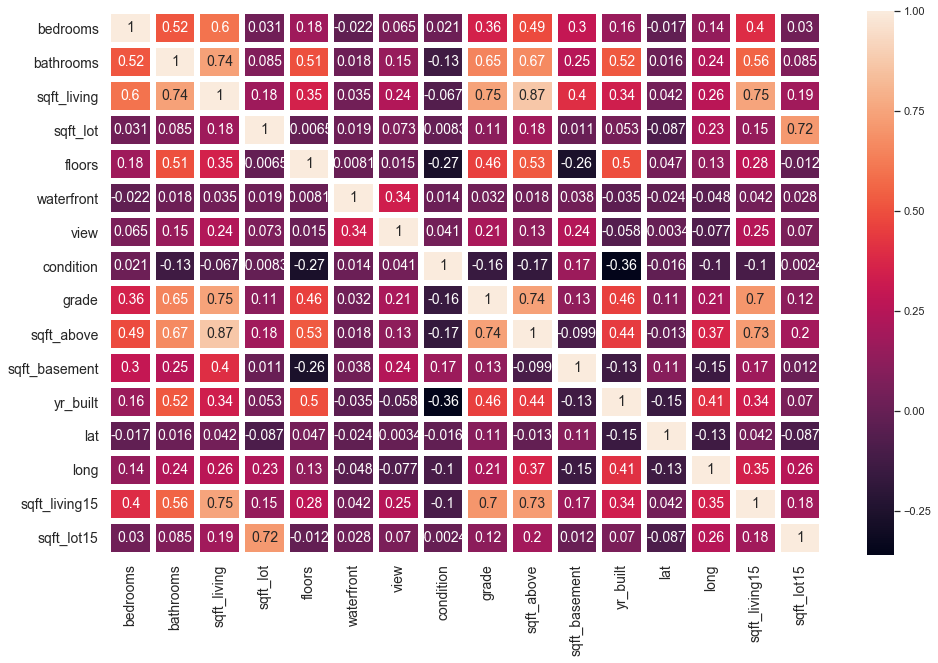

In [7]:
corr_df = kc_corr.corr()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

sns.set(rc={'figure.figsize':(16.0, 10.0)})
ax = sns.heatmap(corr_df, linewidth = 5, annot=True, annot_kws={"size":14})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#plt.figure(figsize=(16,10))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#sns.heatmap(corr_df, linewidth = 5, annot=True, annot_kws={"size":12})

From the correlation map above we can say that 
* not symmetric. negative correlations are closer to zero and not significant
* positive correlations above 0.75 looks quite significant. They are 
     * bathrooms   vs sqft_living   0.76
     * sqft_living vs grade         0.76
     * sqft_living vs sqft_above    0.88
     * sqft_living vs sqft_living15 0.76
     * grade       vs sqft_above    0.76
* sqft_above and sqft_living are highly correlated 
Let's explore those features in a scatter plot 

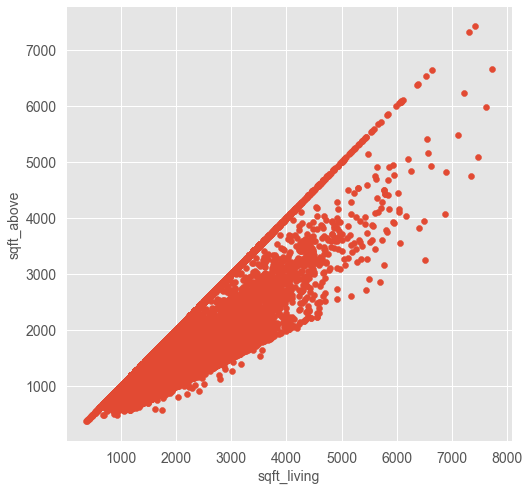

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.xlabel("sqft_living", fontsize=14)
plt.ylabel("sqft_above", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.scatter(kc.sqft_living, kc.sqft_above)

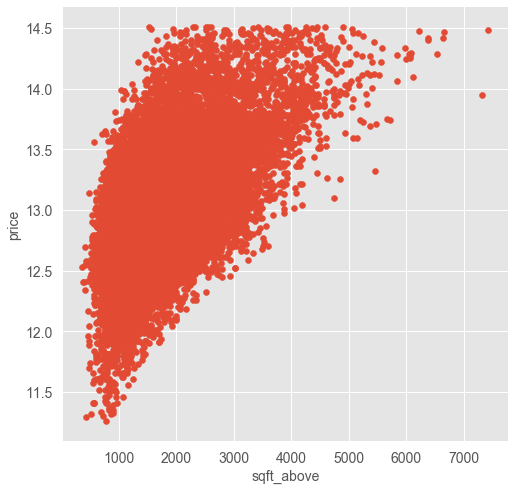

In [9]:
plt.figure(figsize=(8,8))
plt.xlabel("sqft_above", fontsize=14)
plt.ylabel("price", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.scatter(kc.sqft_above, kc.price)

The two features are highly correlated and sqft_above can be dropped. living sqft inlcudes basement space and it more representative of the total area of the house.

In [10]:
kc = kc.drop(['sqft_above'], axis=1) #dropping the sqft_above column from the dataset

### Scatter Matrix
To understand the correlations and data better the scatter matrix is important. Apart from being able to identify possible linear correlations quickly, it allows to identify the categorical features. 

In [ ]:
scatter_matrix = pd.plotting.scatter_matrix(kc_corr, figsize  = [15, 15]);

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 14, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 14, rotation = 0)
plt.show()

What can we see from the scatter matrix above? It's easier to identify categorical variables. 
what are the categorical variables ? 
* floors
* waterfront
* view
* condition
* possibly 'grade' 

## Initial model
To better gauage the progress let's model without any change to the features


In [11]:
# import statistical libraries for modelling. 
import statsmodels.api as sm
from statsmodels.formula.api import ols

### simple linear regression
It maybe worthwhile to investigate correlation between each individual feature with the outcome, which is the price 

In [12]:
predictors = kc.describe().columns[2:19]

for idx, val in enumerate(predictors):
    print("formula = price ~ "+val)
    f = 'price ~ ' + val
    model = ols(formula=f, data=kc).fit()
    print(model.summary())
    print("################################################################################\n\n")


formula = price ~ bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2758.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:49:53   Log-Likelihood:                -14255.
No. Observations:               21398   AIC:                         2.851e+04
Df Residuals:                   21396   BIC:                         2.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3988    

################################################################################


formula = price ~ lat
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     5769.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:49:53   Log-Likelihood:                -12998.
No. Observations:               21398   AIC:                         2.600e+04
Df Residuals:                   21396   BIC:                         2.602e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

### multiple linear regression

In [13]:
#f = 'price ~ zipcode + bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_basement + yr_built + lat + long + sqft_living15 + sqft_lot15'
outcome = 'price'
x_cols = ['zipcode','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
          'grade','sqft_basement','yr_built','lat','long','sqft_living15','sqft_lot15']
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula=f, data=kc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     4017.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:49:55   Log-Likelihood:                -705.06
No. Observations:               21398   AIC:                             1444.
Df Residuals:                   21381   BIC:                             1580.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.7960      3.653     -1.039      0.299     -10.957       3.365
zipcode          -0.0006   4.12e-05    -14.979      0.000      -0.001      -0.001
bedrooms         -0.0134      0.002     -5.372      0.000      -0.018      -0.009
bathrooms         0.0713      0.004     17.450      0.000       0.063       0.079
sqft_living       0.0001    4.8e-06     27.790      0.000       0.000       0.000
sqft_lot       4.796e-07   5.97e-08      8.032      0.000    3.63e-07    5.97e-07
floors            0.0822      0.005     18.254      0.000       0.073       0.091
waterfront        0.3649      0.026     13.863      0.000       0.313       0.416
view              0.0616      0.003     22.800      0.000       0.056       0.067
condition         0.0592      0.003     20.423      0.000       0.054       0.065
grade             0.1577      0.003     58.102      0.000       0.152       0.163
sqft_basement  2.194e-05    5.5e-06      3.990      0.000    1.12e-05    3.27e-05
yr_built         -0.0036   8.68e-05    -41.563      0.000      -0.004      -0.003
lat               1.3882      0.013    103.829      0.000       1.362       1.414
long             -0.1340      0.016     -8.168      0.000      -0.166      -0.102
sqft_living15   9.37e-05   4.39e-06     21.342      0.000    8.51e-05       0.000
sqft_lot15    -2.265e-07   9.13e-08     -2.481      0.013   -4.06e-07   -4.76e-08
==============================================================================
Omnibus:                      315.696   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.866
Skew:                          -0.030   Prob(JB):                    1.23e-131
Kurtosis:                       3.820   Cond. No.                     2.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the P-values it's difficult to remove any features. But what features make sense to change ? 

## Categorical and Numerical features
The categorical and numerical data must be handled appropriately. Some features such as date sold may be binned into seasons, which makes it easier to handle and much less complicated when fitting. Then all other numerical data may be normalized so that much more reasonable fitting parameters may be obtained when fitting. 

### Latitude and Longitude is inherently  correlated and cannot be treated separately

The zipcode, latitude and longitude all shows the location. While zipcode represents a region and inherently a categorical feature. The latitude+longitude is a much more precise measure of location of a given house. While in a single zipcode there may be a wide range of prices in the close neighborhood prices tend to be similar. Although latitude and longitude separately do not provide much useful information, it can be used to calculate distances relative to a fix point in the region. It should be noted that latitude and longitude are essentially angles and need quite complex conversions to transform them to distances. However, for a small enough region and a county they can be approximated to coordinates in a flat plane without loss of generality. The focal point that makes most sense is the official coordinates of Seattle, which is (47.6062, -122.3321). The ‘-’ on longitude represents ‘west’. For a house with coordinates (x1, y1) by applying pythagorean theorem the distance ‘r’ can be calculated as follows 

r = np.sqrt((x1 - 47.6062)^2 + (y1 - 122.3321)^2)


In [14]:
kc['r'] = kc.apply(lambda row: np.sqrt(((row.lat - 47.6062)**2) + ((row.long - (-122.3321))**2)), axis=1)
kc[['lat', 'long', 'r']]

,lat,long,r
0,47.5112,-122.257,0.121099
1,47.7210,-122.319,0.115545
2,47.7379,-122.233,0.164820
3,47.5208,-122.393,0.104890
4,47.6168,-122.045,0.287296
...,...,...,...
21393,47.6993,-122.346,0.094132
21394,47.5107,-122.362,0.100071
21395,47.5944,-122.299,0.035140
21396,47.5345,-122.069,0.272695


In [15]:
# now let's redo the OLS by replacing zipcode, lat and long with 'r'
outcome = 'price'
x_cols = ['r', 'bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
          'grade','sqft_basement','yr_built', 'sqft_living15','sqft_lot15']
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula=f, data=kc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     3205.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:50:05   Log-Likelihood:                -3453.7
No. Observations:               21398   AIC:                             6937.
Df Residuals:                   21383   BIC:                             7057.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.6548      0.192     86.529      0.000      16.278      17.032
r                -1.2182      0.020    -59.734      0.000      -1.258      -1.178
bedrooms         -0.0211      0.003     -7.433      0.000      -0.027      -0.016
bathrooms         0.0701      0.005     15.076      0.000       0.061       0.079
sqft_living       0.0001   5.47e-06     26.689      0.000       0.000       0.000
sqft_lot       6.076e-07   6.79e-08      8.944      0.000    4.74e-07    7.41e-07
floors            0.0602      0.005     11.696      0.000       0.050       0.070
waterfront        0.3480      0.030     11.632      0.000       0.289       0.407
view              0.0341      0.003     11.239      0.000       0.028       0.040
condition         0.0568      0.003     17.374      0.000       0.050       0.063
grade             0.1627      0.003     52.641      0.000       0.157       0.169
sqft_basement -5.262e-06    6.3e-06     -0.835      0.404   -1.76e-05    7.09e-06
yr_built         -0.0028      0.000    -28.229      0.000      -0.003      -0.003
sqft_living15     0.0001    4.9e-06     30.230      0.000       0.000       0.000
sqft_lot15     2.999e-07   1.04e-07      2.878      0.004    9.56e-08    5.04e-07
==============================================================================
Omnibus:                      126.767   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.538
Skew:                          -0.135   Prob(JB):                     1.51e-32
Kurtosis:                       3.303   Cond. No.                     5.01e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
predictors = ['r', 'lat','long','zipcode']

for idx, val in enumerate(predictors):
    print("formula = price ~ "+val)
    f = 'price ~ ' + val
    model = ols(formula=f, data=kc).fit()
    print(model.summary())
    print("################################################################################\n\n")


formula = price ~ r
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1014.
Date:                Sat, 02 May 2020   Prob (F-statistic):          1.59e-217
Time:                        16:50:10   Log-Likelihood:                -15057.
No. Observations:               21398   AIC:                         3.012e+04
Df Residuals:                   21396   BIC:                         3.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.2081      0.006

<b> Is the predictor 'r' better than lat+long or zipcode </b> 
This feature change does reduce the R2 from 0.750 to 0.677. The R^2 of 
* r is 0.045
* lat is 0.212
* long is 0.004
* zipcode is 0.001
it appears that that distance measure 'r' is reducing the accuracy. Lattitude seems to be the best predicter amoung thes. 

In [ ]:
# Let's remove 'r'
#kc = kc.drop(['r'], axis =1 )
#kc = kc.drop(['lat', 'long', 'zipcode'], axis =1 )
# let's just keep it until recursive elimination 

### Categorize 'Date' variable to show season   
The feature 'date' is the date the souse sold in king county. A date data type will not be included in the regression. Thus, it may be better to categorize the date into season. 

C:\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


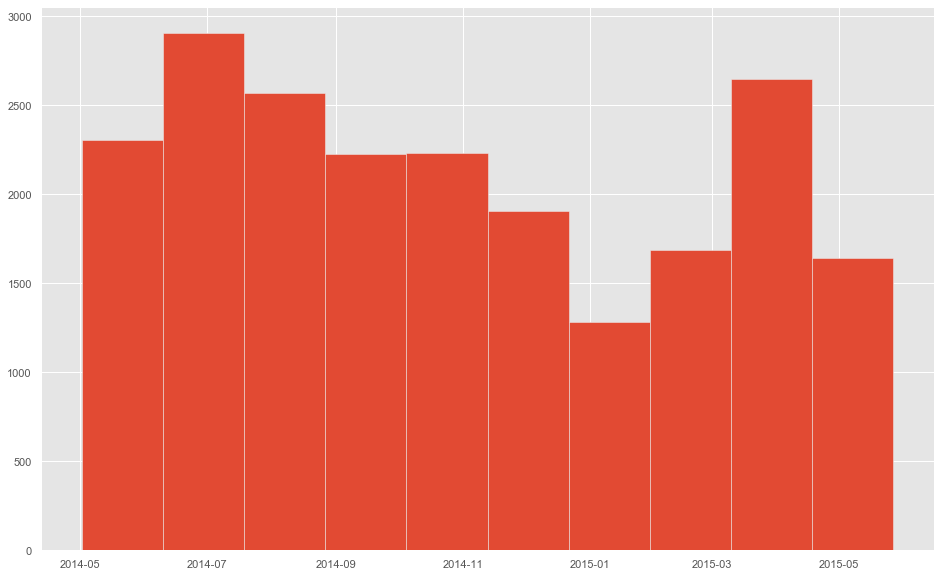

In [17]:
plt.style.use('ggplot')
kc.date.hist()

In [18]:
kc['month'] = kc['date'].dt.month # add a month column to the dataframe
kc.month.unique()

array([10, 12,  2,  5,  6,  1,  4,  3,  7,  8, 11,  9], dtype=int64)

0          fall
1        winter
2        winter
3        winter
4        winter
          ...  
21393    spring
21394    winter
21395    spring
21396    winter
21397      fall
Name: season, Length: 21398, dtype: category
Categories (4, object): [winter, spring, summer, fall]

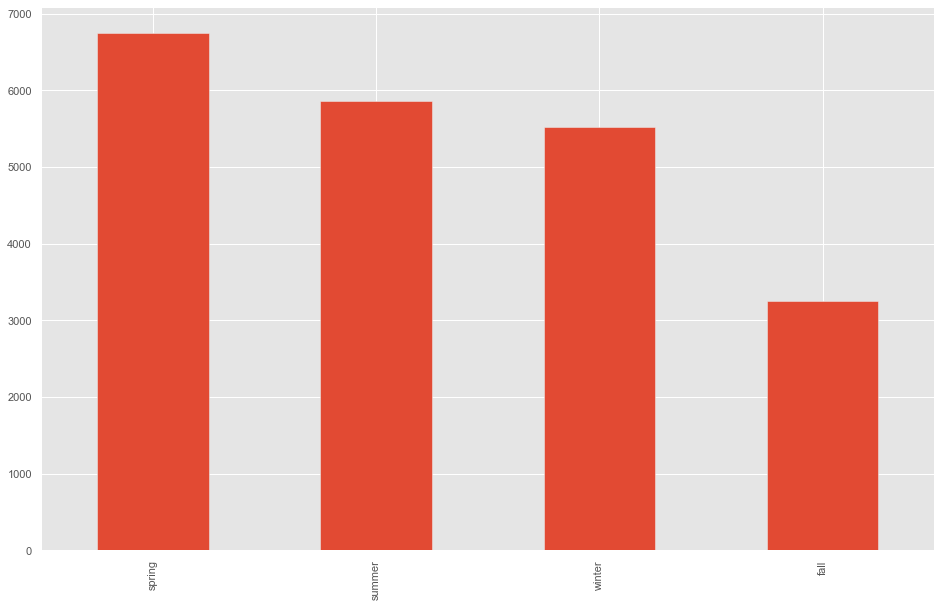

In [19]:
kc.month = kc.month.replace(12, 0) # change 12 to 0 so that 0-2 represent winter
#creating bins for the season
bins = [0, 3, 6, 9, 11]
kc['season'] = pd.cut(kc['month'], bins, include_lowest = True, labels = ["winter", "spring", "summer", "fall"])
kc['season'] = kc['season'].cat.as_unordered()
kc['season'].value_counts().plot(kind='bar')
kc.season

### prepare other categorical features to sting   

In [20]:
#print(kc.columns[0:20])
check_cat = ['waterfront', 'condition', 'floors', 'view', 'grade', 'sqft_basement']
                      
for feature in check_cat:
    print("unique values of \'{}\' predictor".format(feature))
    display(kc[feature].value_counts())

unique values of 'waterfront' predictor


0.0    21295
1.0      103
Name: waterfront, dtype: int64

unique values of 'condition' predictor


3    13899
4     5631
5     1670
2      169
1       29
Name: condition, dtype: int64

unique values of 'floors' predictor


1.0    10638
2.0     8106
1.5     1898
3.0      607
2.5      143
3.5        6
Name: floors, dtype: int64

unique values of 'view' predictor


0.0    19414
2.0      930
3.0      483
1.0      317
4.0      254
Name: view, dtype: int64

unique values of 'grade' predictor


7     8972
8     6060
9     2597
6     2038
10    1075
11     329
5      242
12      56
4       27
13       1
3        1
Name: grade, dtype: int64

unique values of 'sqft_basement' predictor


0.0       13225
600.0       215
500.0       209
700.0       205
800.0       200
          ...  
602.0         1
1281.0        1
915.0         1
2130.0        1
1890.0        1
Name: sqft_basement, Length: 291, dtype: int64

The numerical variable looks catergorical. However, except wavefront rest can be assumed as a numerical data for the puspose of regression. 
let's encode wavefront onto string. 

In [21]:
kc['waterfront'] = kc['waterfront'].astype("str")

In [22]:
kc.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'r', 'month', 'season'],
      dtype='object')

In [23]:
# let's remove unnecessary and binned 
kc = kc.drop(['date', 'month'], axis =1 )

### One-Hot Encoding to handle the categorical features 

In [24]:
kc = pd.get_dummies(kc) #one-hot encoding our data
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 24 columns):
id                21398 non-null int64
price             21398 non-null float64
bedrooms          21398 non-null int64
bathrooms         21398 non-null float64
sqft_living       21398 non-null float64
sqft_lot          21398 non-null float64
floors            21398 non-null float64
view              21398 non-null float64
condition         21398 non-null int64
grade             21398 non-null int64
sqft_basement     21398 non-null float64
yr_built          21398 non-null int64
zipcode           21398 non-null int64
lat               21398 non-null float64
long              21398 non-null float64
sqft_living15     21398 non-null float64
sqft_lot15        21398 non-null float64
r                 21398 non-null float64
waterfront_0.0    21398 non-null uint8
waterfront_1.0    21398 non-null uint8
season_winter     21398 non-null uint8
season_spring     21398 non-null uint8
season_su

In [25]:
kc.rename(columns={'waterfront_0.0' : 'waterfront_0', 'waterfront_1.0' : 'waterfront_1'}, inplace=True)

In [26]:
kc.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'r',
       'waterfront_0', 'waterfront_1', 'season_winter', 'season_spring',
       'season_summer', 'season_fall'],
      dtype='object')

## Min-Max Normalization
Min-max normalization make most sense for this data. 


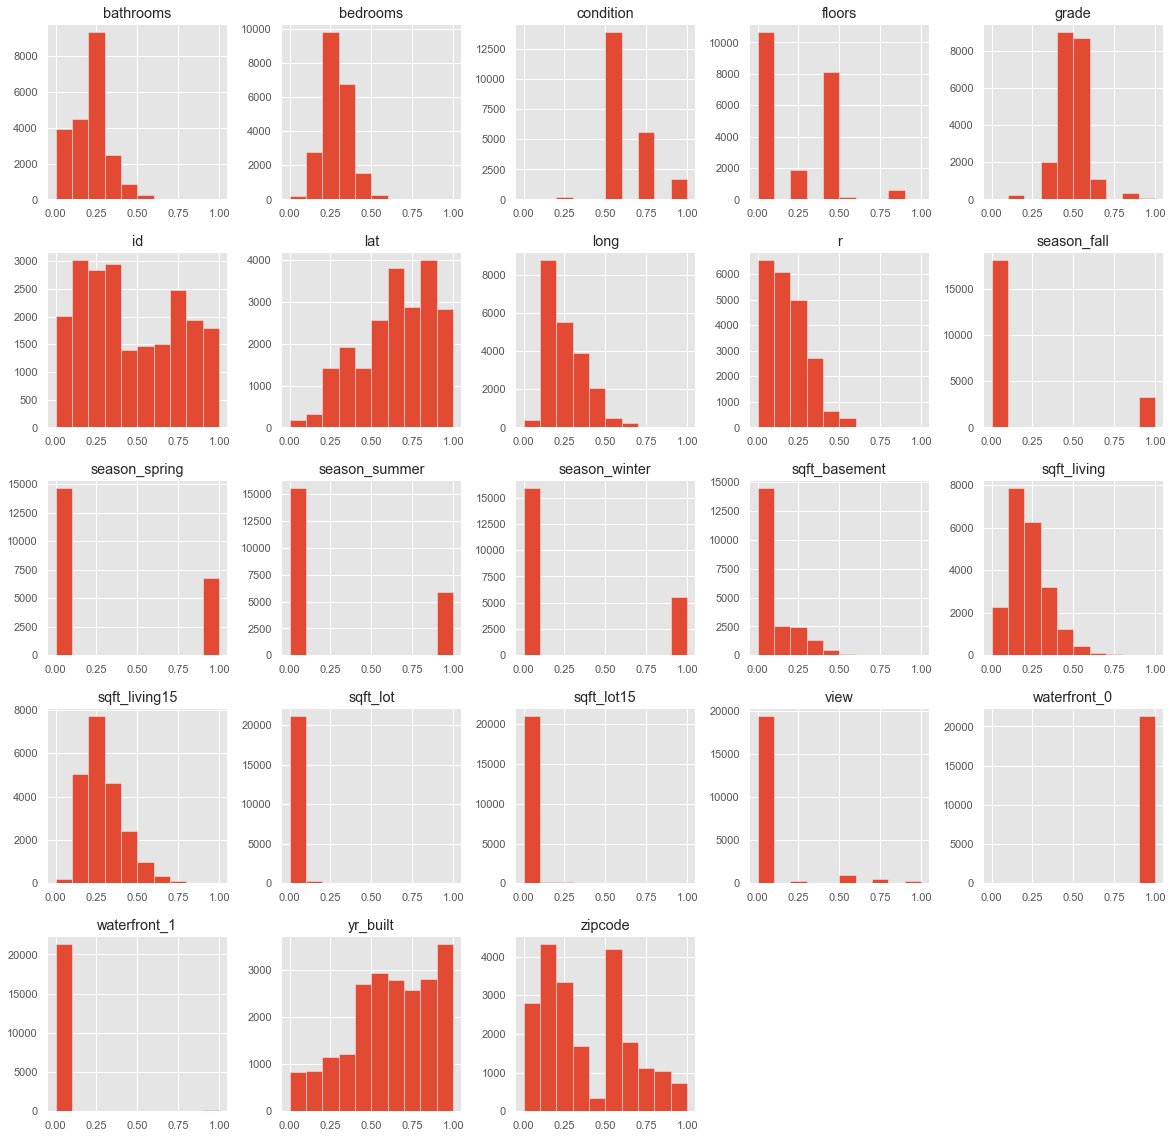

In [27]:
# min-max scaler (normalization using y= (x-min)/(max-min))
from sklearn.preprocessing import MinMaxScaler 

#let's drop the price for it's not included in the normalize
kc_norm = kc.drop(['price'], axis =1 )

scaler = MinMaxScaler() # instantiate 
kc_norm = pd.DataFrame(scaler.fit_transform(kc_norm), columns = kc_norm.columns)
kc_norm.hist(figsize = (20,20));

In [28]:
#display(kc_norm.columns)
# add the price column to the mean normalized dataset. 
kc_norm['price']=kc['price']
#display(kc_norm.columns)
kc_norm.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_basement,...,sqft_living15,sqft_lot15,r,waterfront_0,waterfront_1,season_winter,season_spring,season_summer,season_fall,price
0,0.720103,0.2,0.071429,0.110054,0.003108,0.0,0.0,0.5,0.4,0.000000,...,0.174550,0.005742,0.106968,1.0,0.0,0.0,0.0,0.0,1.0,12.309982
1,0.647853,0.2,0.250000,0.298913,0.004072,0.4,0.0,0.5,0.4,0.122699,...,0.239473,0.008027,0.101466,1.0,0.0,1.0,0.0,0.0,0.0,13.195614
2,0.568795,0.1,0.071429,0.054348,0.005743,0.0,0.0,0.5,0.3,0.000000,...,0.430532,0.008513,0.150274,1.0,0.0,1.0,0.0,0.0,0.0,12.100712
3,0.251157,0.3,0.357143,0.216033,0.002714,0.0,0.0,1.0,0.4,0.279141,...,0.178260,0.004996,0.090913,1.0,0.0,1.0,0.0,0.0,0.0,13.311329
4,0.197333,0.2,0.214286,0.177989,0.004579,0.0,0.0,0.5,0.5,0.000000,...,0.259878,0.007871,0.271586,1.0,0.0,1.0,0.0,0.0,0.0,13.142166


In [29]:
kc_norm.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'r', 'waterfront_0',
       'waterfront_1', 'season_winter', 'season_spring', 'season_summer',
       'season_fall', 'price'],
      dtype='object')

### Let's redo OLS after normalization

In [44]:
# one col from each category can be dropped because one would be linearly dependnt. 
kc_final = kc_norm.drop(['waterfront_0', 'season_winter'], axis =1 )
kc_final = kc_final.drop(['lat','long'], axis =1 )

In [45]:
display(kc_final.columns)
#display(kc_final.columns[15:18])

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'r', 'waterfront_1',
       'season_spring', 'season_summer', 'season_fall', 'price'],
      dtype='object')

In [46]:
#cols_season=kc_final.columns[15:18]

In [47]:
predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'waterfront_1']

for idx, val in enumerate(predictors):
    print("formula = price ~ "+val)
    f = 'price ~ ' + val
    model = ols(formula=f, data=kc_final).fit()
    print(model.summary())
    print("################################################################################\n\n")


formula = price ~ bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2758.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:58:55   Log-Likelihood:                -14255.
No. Observations:               21398   AIC:                         2.851e+04
Df Residuals:                   21396   BIC:                         2.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.5871    

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
################################################################################


formula = price ~ sqft_lot15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sat, 02 May 2020   Prob (F-statistic):           1.38e-40
Time:                        16:58:55   Log-Likelihood:                -15463.
No. Observations:               21398   AIC:                         3.093e+04
Df Residuals:                   21396   BIC:                         3.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
      

In [50]:
display(kc_final.columns[1:19])

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'r', 'waterfront_1', 'season_spring',
       'season_summer', 'season_fall'],
      dtype='object')

In [51]:
# sanity check 
outcome = 'price'
x_cols = kc_final.columns[1:19]
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula=f, data=kc_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     2566.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:59:43   Log-Likelihood:                -3239.7
No. Observations:               21398   AIC:                             6517.
Df Residuals:                   21379   BIC:                             6669.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.1457      0.017    732.153      0.000      12.113      12.178
bedrooms         -0.2445      0.028     -8.702      0.000      -0.300      -0.189
bathrooms         0.4723      0.032     14.649      0.000       0.409       0.535
sqft_living       1.1151      0.040     27.947      0.000       1.037       1.193
sqft_lot          1.0078      0.111      9.074      0.000       0.790       1.225
floors            0.1676      0.013     13.125      0.000       0.143       0.193
view              0.1614      0.012     13.343      0.000       0.138       0.185
condition         0.1991      0.013     15.258      0.000       0.174       0.225
grade             1.6008      0.031     52.247      0.000       1.541       1.661
sqft_basement    -0.0144      0.020     -0.710      0.478      -0.054       0.025
yr_built         -0.3490      0.012    -30.343      0.000      -0.372      -0.326
zipcode          -0.1771      0.009    -19.619      0.000      -0.195      -0.159
sqft_living15     0.7317      0.026     27.765      0.000       0.680       0.783
sqft_lot15        0.2939      0.090      3.270      0.001       0.118       0.470
r                -1.4215      0.023    -62.807      0.000      -1.466      -1.377
waterfront_1      0.3538      0.030     11.939      0.000       0.296       0.412
season_spring     0.0197      0.005      3.855      0.000       0.010       0.030
season_summer    -0.0085      0.005     -1.609      0.108      -0.019       0.002
season_fall      -0.0178      0.006     -2.855      0.004      -0.030      -0.006
==============================================================================
Omnibus:                      153.044   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.711
Skew:                          -0.160   Prob(JB):                     1.90e-38
Kurtosis:                       3.305   Cond. No.                         112.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's keep predictors that had r2 values greater than or equal to .1.

R^2 < 0.1 predictors ==> sqft_lot, condition, yr_built, zipcode, long, sqft_lot15, waterfront_1, season_spring, season_summer, season_fall

In [ ]:
#del_cols=['sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15', 'waterfront_1', 'season_spring', 'season_summer', 'season_fall']
#kc_final = kc_final.drop(del_cols, axis =1 )
#display(kc_final.columns)

In [ ]:
#display(kc_final.columns[1:10])

In [ ]:
# now let's redo the OLS 
#outcome = 'price'
#x_cols = kc_final.columns[1:20]
#predictors = '+'.join(x_cols)
#f = outcome + '~' + predictors
#model = ols(formula=f, data=kc_final).fit()
#model.summary()

In [ ]:
display(kc.sqft_basement.value_counts())
kc.sqft_basement.hist()

In [ ]:
kc_norm.info()

In [52]:
#creating a matrix with our predictor and target variables
y = kc_final[["price"]] 
X = kc_final.drop(["price"], axis=1) 
X.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,r,waterfront_1,season_spring,season_summer,season_fall
0,0.720103,0.2,0.071429,0.110054,0.003108,0.0,0.0,0.5,0.4,0.000000,0.478261,0.893939,0.174550,0.005742,0.106968,0.0,0.0,0.0,1.0
1,0.647853,0.2,0.250000,0.298913,0.004072,0.4,0.0,0.5,0.4,0.122699,0.443478,0.626263,0.239473,0.008027,0.101466,0.0,0.0,0.0,0.0
2,0.568795,0.1,0.071429,0.054348,0.005743,0.0,0.0,0.5,0.3,0.000000,0.286957,0.136364,0.430532,0.008513,0.150274,0.0,0.0,0.0,0.0
3,0.251157,0.3,0.357143,0.216033,0.002714,0.0,0.0,1.0,0.4,0.279141,0.565217,0.681818,0.178260,0.004996,0.090913,0.0,0.0,0.0,0.0
4,0.197333,0.2,0.214286,0.177989,0.004579,0.0,0.0,0.5,0.5,0.000000,0.756522,0.368687,0.259878,0.007871,0.271586,0.0,0.0,0.0,0.0


In [53]:
#now we will commence feature ranking
from sklearn.feature_selection import RFE #first we are importing the necessary libraries
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [54]:
r_list = [] #creating lists to store r squared and r squared adjusted
adj_r_list = []
list_n = list(range(2,21,1)) #creating a loop where we find the 5 best features and then go up by increments of 10 until we have the 65 best features 
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n) #selecting the pre-specified n most important features
    select_n = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_ ]
    linreg.fit(X[selected_columns],y)
    yhat = linreg.predict(X[selected_columns])
    SS_Residual = np.sum((y-yhat)**2) 
    SS_Total = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    print(r_squared)
    print(n)
    print(selected_columns)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print(adjusted_r_squared)
    print("\n\n")
r_list.append(r_squared)
adj_r_list.append(adjusted_r_squared)

price    0.520533
dtype: float64
2
Index(['sqft_living', 'grade'], dtype='object')
price    0.520107
dtype: float64



price    0.520626
dtype: float64
3
Index(['sqft_living', 'sqft_lot', 'grade'], dtype='object')
price    0.5202
dtype: float64



price    0.629196
dtype: float64
4
Index(['sqft_living', 'sqft_lot', 'grade', 'r'], dtype='object')
price    0.628867
dtype: float64



price    0.644967
dtype: float64
5
Index(['sqft_living', 'sqft_lot', 'grade', 'sqft_living15', 'r'], dtype='object')
price    0.644652
dtype: float64



price    0.650285
dtype: float64
6
Index(['sqft_living', 'sqft_lot', 'grade', 'sqft_living15', 'r',
       'waterfront_1'],
      dtype='object')
price    0.649974
dtype: float64



price    0.650736
dtype: float64
7
Index(['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'sqft_living15', 'r',
       'waterfront_1'],
      dtype='object')
price    0.650425
dtype: float64



price    0.667734
dtype: float64
8
Index(['bathrooms', 'sqft_living', 'sqft_lot', 'gra

In [ ]:
kc_optimal = kc_final[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'yr_built', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'waterfront_1']]

## All data is normalized and ready for validation
Save the clean data to a kc_house_data_clean.csv file

In [ ]:
kc_norm.to_csv('data/kc_house_data_normalized.csv', index=False)

<p style="font-size:200%; text-align:center">Please open validation.ipynb next for final model</p>